In [14]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import operator

load_dotenv()

Gemini = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')
Gemini2 = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [15]:
from langgraph.graph import add_messages

# Define State
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# Creating Node
def Chat(state: ChatState) -> dict:
    message = state['messages']
    res = Gemini.invoke(message)
    return {'messages': [res]}


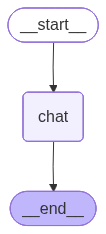

In [16]:
# Create Graph
chatGraph = StateGraph(ChatState)

# Adding Nodes
chatGraph.add_node("chat", Chat)

# Connecting Edges
chatGraph.add_edge(START, "chat")
chatGraph.add_edge("chat", END)

# Compling Graph
chatWorkflow = chatGraph.compile()
chatWorkflow

In [11]:
initial_state = {
    'messages': [HumanMessage(content="What is Capital oh Bihar?")]
}

finalState = chatWorkflow.invoke(initial_state)
finalState

{'messages': [HumanMessage(content='What is Capital oh Bihar?', additional_kwargs={}, response_metadata={}, id='b280b784-f6a7-4379-8f05-197c0a2cfe2c'),
  AIMessage(content='The capital of Bihar is **Patna**.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc5b3-5bb5-7c12-921b-e7e38063c689-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 9, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})]}

In [ ]:
# Continuous Chat without Context
while True:
    userMsg = input('Type Here:')
    print(f'User: {userMsg}')
    if userMsg.strip().lower() in ['bye', 'end', 'exit']:
        print('Chat Ended.')
        break
    res = chatWorkflow.invoke({'messages': [HumanMessage(content=userMsg)]})
    print(f'AI: {res['messages'][-1].content}', end='\n')

User: hey, i am vivek
AI: Hi Vivek! It's nice to meet you. How can I help you today?
User: can you add 23 and 29
AI: 23 + 29 = 52
User: now multyply the result by 17
AI: Please provide me with the result of the previous calculation. I need to know what number to multiply by 17.
User: end
Chat Ended.


In [18]:
# Continuous Chat without Context
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

chatGraph = StateGraph(ChatState)    # Create Graph
chatGraph.add_node("chat", Chat)     # Adding Nodes
chatGraph.add_edge(START, "chat")    # Connecting Edges
chatGraph.add_edge("chat", END)
chatWorkflow = chatGraph.compile(checkpointer=checkpointer)   # Compling Graph

thread_id = '1'

while True:
    userMsg = input('Type Here:')
    print(f'User: {userMsg}')
    if userMsg.strip().lower() in ['bye', 'end', 'exit']:
        print('Chat Ended.')
        break
    config = {'configurable': {'thread_id': thread_id}}
    res = chatWorkflow.invoke({'messages': [HumanMessage(content=userMsg)]}, config=config)
    print(f'AI: {res['messages'][-1].content}', end='\n')

User: hey, my name is vivek
AI: Hi Vivek, it's nice to meet you! How can I help you today?
User: can you add 23 and 29
AI: Sure, 23 + 29 = 52.
User: now multyply the result by 17
AI: Okay, so the result of 23 + 29 was 52.

Now, multiplying 52 by 17:

52 * 17 = 884
User: can you guess my name?
AI: Well, you did tell me your name earlier: **Vivek**. So, I can guess your name is Vivek! 😊
User: bye
Chat Ended.


In [19]:
chatWorkflow.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='hey, my name is vivek', additional_kwargs={}, response_metadata={}, id='5bed31c2-b04f-424c-a2d3-8066f9041208'), AIMessage(content="Hi Vivek, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc5ca-dec9-7d22-9fb3-2aaf30b97355-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 18, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='can you add 23 and 29', additional_kwargs={}, response_metadata={}, id='a533327b-6284-4501-975f-d81a13a6525d'), AIMessage(content='Sure, 23 + 29 = 52.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc5cb-16f7-7a02-b461-55264